In [1]:
import time
import tensorflow as tf
tf.random.set_seed(5)
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical, to_ordinal
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import keras_tuner as kt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score

## 1 Импортируем Fashion MNIST датасет

In [2]:
from keras.datasets import fashion_mnist

## 2 Загрузка данных с параллельным разбиением на тестувую и тренировочную выборки

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


## 3 Нормализация дпнных

In [4]:
train_images = (train_images / 255)
test_images = (test_images / 255)

## 4 Предварительный просмотр

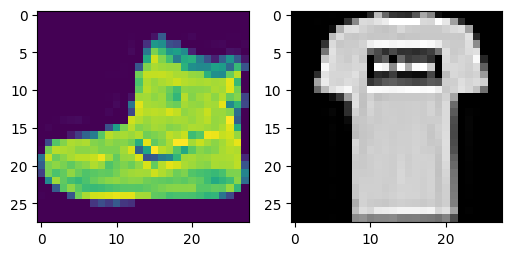

In [5]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(train_images[0])
plt.subplot(1,2,2)
plt.imshow(train_images[1], cmap='gray')

### Содержание классов датасета

Датасет содержит следующие классы:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Каждому классу обозначенному цифрой мы можем присвоить текстовое значение -

## 5 Классификация таргета

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#### Для процесса обучения нейронной сети нам важно перевести данные из диапазона от 0 до 255 в диапазон от 0 до 1:

## 6 Создание моделей

In [31]:
MyModel = {}

model1 = tf.keras.Sequential([
    keras.layers.Input(shape=(784,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(10)
])

model2 = tf.keras.Sequential([
    keras.layers.Input(shape=(784,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(10)
])

model3= keras.Sequential([
    keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D((2,2), strides=2),
    keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2,2), strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10)
])

## 7 Определение списков функций потерь и оптимизаторов

In [32]:
opt_adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
opt_rmsp = tf.keras.optimizers.legacy.RMSprop()
opt_sgd = tf.keras.optimizers.legacy.SGD()

loss_scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

## 8 Сборка общей модели

In [33]:
MyModel['models'] = [model1, model2, model3]
MyModel['optimizers'] = [opt_adam, opt_rmsp, opt_sgd]
MyModel['losses'] = [loss_scce]

## 9 Реализаци функций

In [35]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


def recall_precision(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
    recall_precision_dict = {}
    precision = precision_score(y_true, y_pred, labels=labels, average=None)
    recall = recall_score(y_true, y_pred, labels=labels, average=None)
    for i, el in enumerate(zip(precision, recall)):
        recall_precision_dict[f'Класс - {i}'] = [round(el[0],3), round(el[1],3)]
    return recall_precision_dict


def To_Flatten(X_train, X_test):
    X_train_new = X_train.reshape((-1, 784))
    X_test_new = X_test.reshape((-1, 784))
    return X_train_new, X_test_new



def compile_models(Model, X_train, X_test, y_train, y_test, model_batch=250, model_epoch=10, model_metrics='accuracy'):
    """Функция осуществляет подбор наилудчшей модели с несколькими оптимизаторами"""
    print("Start")
    start = time.time()
    result_dict = {}
    X_train_new, X_test_new = To_Flatten(X_train, X_test)
    for n1, model in enumerate(Model['models']): # Для каждой модели
        n1 += 1
        if n1 == 3:
            X_train = np.expand_dims(X_train, axis=3)
            X_test = np.expand_dims(X_test, axis=3)
        for n2, model_optimazer in enumerate(Model['optimizers']): # Для каждого оптимизатора
            n2 += 1
            for n3, loss_i in enumerate(Model['losses']): # Для каждой функции потерь
                n3 += 1
                # Компиляция модели
                print(f'Компиляция модели: Model {n1}  Optimizer {n2}  Loss {n3}  Batch={model_batch}  Epochs={model_epoch}  Metrics={model_metrics}')
                model.compile(optimizer=model_optimazer, loss=loss_i, metrics=[model_metrics])
                # Обучение модели
                print(f'Обучение модели: Model {n1}  Optimizer {n2} Loss {n3}  Batch={model_batch}  Epochs={model_epoch}  Metrics={model_metrics}')
                if n1 == 3:
                    model.fit(X_train, y_train, batch_size=model_batch, epochs=model_epoch, validation_split=0.2, verbose=0)
                else:
                    model.fit(X_train_new, y_train, batch_size = model_batch, epochs=model_epoch, verbose=0)
                # Оценка модели
                print(f'Оценка модели: Model {n1}  Optimizer {n2}  Loss {n3}  Batch={model_batch}  Epochs={model_epoch}  Metrics={model_metrics}')
                if n1 == 3:
                    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
                else:
                    test_loss, test_acc = model.evaluate(X_test_new,  y_test, verbose=0)
                # Запись результатов оценки модели в словарь
                # Лучшая модель будет определяться по наибольшемы результату метрики accuracy
                print(f'Запись результатов: Model {n1}  Optimizer {n2}  Loss {n3}  Batch={model_batch}  Epochs={model_epoch}  Metrics={model_metrics}')
                print("*"*90)
                result_dict[f'Model_{n1}__Optimizer_{n2}__Loss_{n3}'] = test_acc

    model_keys_list = list(result_dict.keys())
    model_values_list = list(result_dict.values())

    best_accuracy = max(model_values_list)
    count_best_accuracy = model_values_list.count(best_accuracy)

    best_model_dict = {}

    print('Определение наилудчшей модели')
    for acc in range(count_best_accuracy):
        model_keys_list = list(result_dict.keys())
        model_values_list = list(result_dict.values())
        if best_accuracy in model_values_list:
            acc_index = model_values_list.index(best_accuracy)
            best_model_dict[model_keys_list[acc_index]] = best_accuracy
            result_dict.pop(model_keys_list[acc_index])
        else:
            break
    stop = time.time()
    print("Time", stop - start)
    return best_model_dict

## 10 Запуск подбора

In [15]:
best_model = compile_models(MyModel, train_images, test_images, train_labels, test_labels)

Start
Компиляция модели: Model 1  Optimizer 1  Loss 1  Batch=250  Epochs=10  Metrics=accuracy
Обучение модели: Model 1  Optimizer 1 Loss 1  Batch=250  Epochs=10  Metrics=accuracy
Оценка модели: Model 1  Optimizer 1  Loss 1  Batch=250  Epochs=10  Metrics=accuracy
Запись результатов: Model 1  Optimizer 1  Loss 1  Batch=250  Epochs=10  Metrics=accuracy
******************************************************************************************
Компиляция модели: Model 1  Optimizer 2  Loss 1  Batch=250  Epochs=10  Metrics=accuracy
Обучение модели: Model 1  Optimizer 2 Loss 1  Batch=250  Epochs=10  Metrics=accuracy
Оценка модели: Model 1  Optimizer 2  Loss 1  Batch=250  Epochs=10  Metrics=accuracy
Запись результатов: Model 1  Optimizer 2  Loss 1  Batch=250  Epochs=10  Metrics=accuracy
******************************************************************************************
Компиляция модели: Model 1  Optimizer 3  Loss 1  Batch=250  Epochs=10  Metrics=accuracy
Обучение модели: Model 1  Optimi

In [16]:
best_model

{'Model_3__Optimizer_3__Loss_1': 0.9185000061988831}

## 11 Получение предсказаний по наилудчшей модели

In [19]:
X_train_images = np.expand_dims(train_images, axis=3)
X_test_images = np.expand_dims(test_images, axis=3)

In [28]:
probability_model = tf.keras.Sequential([model3, tf.keras.layers.Softmax()])
predictions = probability_model.predict(X_test_images, verbose=0)
y_pred = np.argmax(predictions, axis=1)

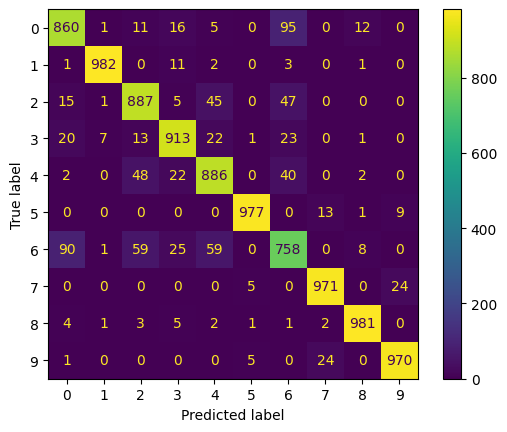

In [29]:
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)

## 12 Просмотр точности и полноты модели для кажддого класса

In [22]:
recall_precision(test_labels, y_pred)

{'Класс - 0': [0.866, 0.86],
 'Класс - 1': [0.989, 0.982],
 'Класс - 2': [0.869, 0.887],
 'Класс - 3': [0.916, 0.913],
 'Класс - 4': [0.868, 0.886],
 'Класс - 5': [0.988, 0.977],
 'Класс - 6': [0.784, 0.758],
 'Класс - 7': [0.961, 0.971],
 'Класс - 8': [0.975, 0.981],
 'Класс - 9': [0.967, 0.97]}

### 13 Вывод изображение и показателя отношения его к классу определенного моделью

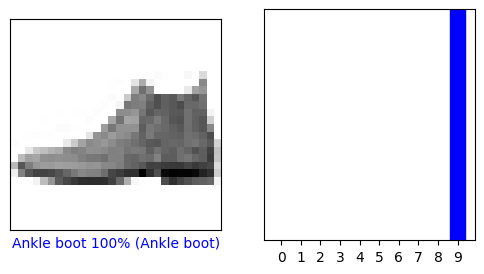

In [24]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

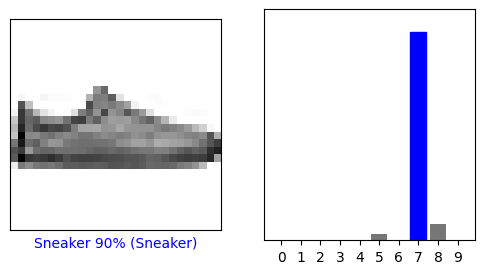

In [25]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

### 14 Вывод нескольких изображений с определенными для них классами

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


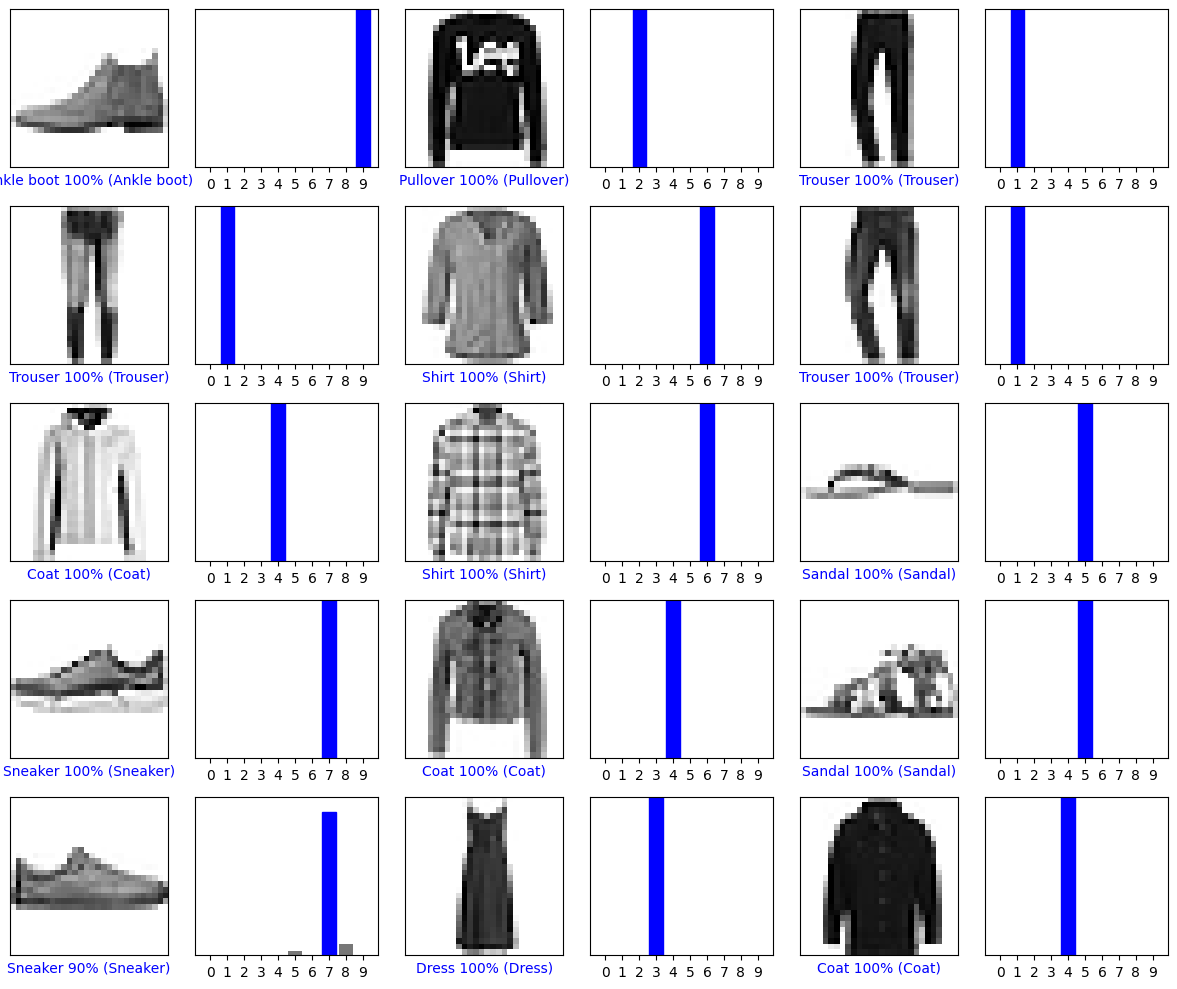

In [26]:
print(class_names)
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Вывод по результатам подбора наилудчшей модели была определена model3 с использованием конвертируемых слоев и MaxPooling слоев.
Наилудчший оптимизатор для модели был определен SGD стохаический градиентный спуск
Функция потерь использовалась sparsecategoricalcrossentropy